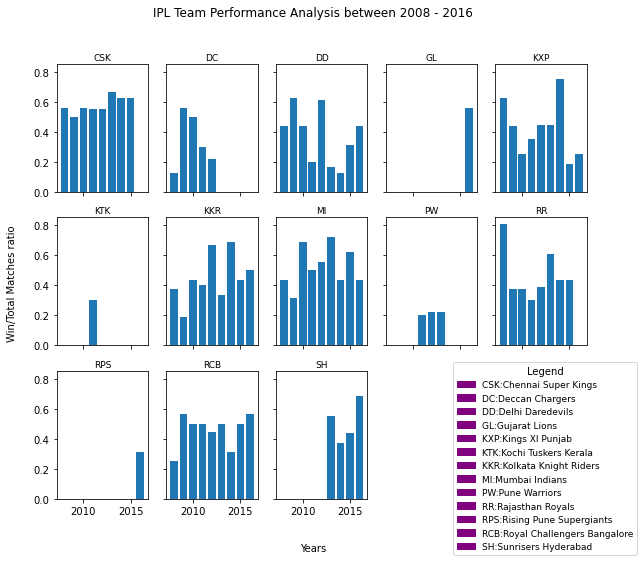

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline

# Reading csv files
t20_series = pd.read_csv("t20_series.csv")
t20_matches = pd.read_csv("t20_matches.csv")

start_year = 2008
def inc_season(x):
    global start_year
    x = str(start_year)
    start_year += 1
    return x

# Cleaning t20_series dataframe
def clean_t20_series():
    df = t20_series[(t20_series["series"] == "Indian Premier League (in India)") | (t20_series["series"] == "Indian Premier League (in South Africa)") | (t20_series["series"] == "Pepsi Indian Premier League (in India)") | (t20_series["series"] == "Pepsi Indian Premier League (in India/United Arab Emirates)")]
    df = df.drop(labels=["margin"], axis=1)
    df["season"] = df["season"].apply(inc_season)
    return df

def get_series_id():
    df = clean_t20_series()
    series_id = df["series_id"].tolist()
    return series_id

remove_row = []
row_counter = 0

def remove_columns(x):
    global row_counter
    global remove_row
    if x.find("Match abandoned without a ball bowled") != -1 or x.find("No result") != -1:
        remove_row.append(row_counter)
    row_counter += 1
    return 

def remove_year(x):
    global row_counter
    global remove_row
    if x == "2017":
        remove_row.append(row_counter)
    row_counter += 1
    return 

# Cleaning t20_matches dataframe
def clean_t20_matches():
    global remove_row
    global row_counter
    series_id = get_series_id()
    df = t20_matches
    df = df[df["series_id"].map(lambda x:x in series_id)]
    df["winner"].apply(remove_columns)
    df = df.drop(df.index[remove_row])
    
    keep_col = [
        "match_id",
        "series_id",
        "date",
        "winner"
    ]
    df = df[keep_col]
    df["year"] = df["date"].apply(lambda x:x[-4:])
    df = df.drop(labels=["date"], axis=1)
    
    remove_row = []
    row_counter = 0
    df["year"].apply(remove_year)
    df = df.drop(df.index[remove_row])
    return df

df_match = clean_t20_matches()
df_series = clean_t20_series()

# Get all teams participated in IPL
def get_teams():
    results = df_match["winner"]
    teams = results.tolist()
    teams = set(teams)
    return teams

new_series = df_match[["year", "winner"]].groupby(by=["year", "winner"]).size()
new_df = pd.DataFrame()
new_df["wins"] = new_series
new_df = new_df.reset_index()
teams = new_df.groupby(by=["year"])["winner"].size()
teams = teams.tolist()

start_year = 2008
def my_func(x):
    total_matches = teams[int(x[0]) - start_year] * 2
    return x[2] / total_matches

# Calculate win ratio for all teams
new_df["win_ratio"] = new_df.apply(my_func, axis=1)

plot_df = pd.pivot_table(data=new_df, index="winner", columns=["year"], fill_value=0)
plot_df = plot_df.drop(labels=["wins"], axis=1)
plot_df.columns = np.arange(2008, 2017)

# Plot win ratios
x_val = np.arange(2008, 2017)    
ax_list = [[] for x in range(3)]
fig, ax_list = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(9.5, 8))

def get_name(team):
    team = team.split(" ")
    name = [x[0] for x in team]
    return "".join(name)

i, j = 0, 0
teams = []
for team, win_ratio in plot_df.iterrows():
    ax_list[i][j].bar(x_val, win_ratio)
    team_name = get_name(team)
    ax_list[i][j].set_xlabel(team_name, fontsize=9)
    ax_list[i][j].xaxis.set_label_position('top') 
    if j == 4:
        j, i = 0, i + 1
    else:
        j += 1
    teams.append((team, team_name))

# Create custom legend
fig.legend([mpatches.Patch(color='purple') for x in teams], [x[1] + ":" + x[0] for x in teams], fontsize=9, loc=4, bbox_to_anchor=(0.98, 0.02), title="Legend")

# Remove extra subplots
fig.delaxes(ax_list[2][3])
fig.delaxes(ax_list[2][4])

fig.suptitle("IPL Team Performance Analysis between 2008 - 2016", fontsize=12)
_ = fig.text(0.5, 0.04, 'Years', ha='center', va='center')
_ = fig.text(0.06, 0.5, 'Win/Total Matches ratio', ha='center', va='center', rotation='vertical')